In [1]:
import seaborn as sns 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/updated_housing_data.csv')
df = df[['price', 'grade', 'bedrooms', 'sqft_living', 'sqft_lot15', 'sqft_basement', 'zipcode']]
print(df.shape)
def get_clean_data(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        mean = df[col].mean()
        std = df[col].std()
        df = df[(df[col] < (mean + 5*std)) & (df[col] > (mean - 5*std))]
    return df

df = get_clean_data(df)
print(df.shape)

(21597, 7)
(21198, 7)


/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


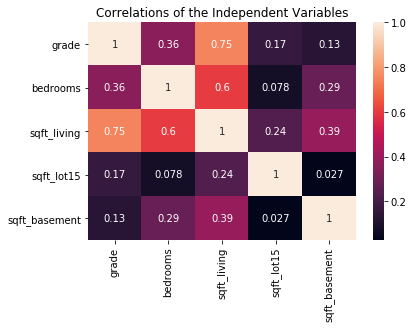

In [3]:
def get_heatmap(df):
    '''This function will create a heatmap to compare the different independent variables of our model'''
    sns.heatmap(df.drop(['price', 'zipcode'], axis = 1).corr(), annot = True)
    plt.title('Correlations of the Independent Variables')
    
get_heatmap(df)

### Regression

In [4]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm 
import pandas as pd

In [5]:
X = df[[i for i in df.columns if i != 'price']]
y = df[['price']]/1000000
X = sm.add_constant(X)
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state = 0, train_size = .8, stratify = X.zipcode.values)
x_train.drop('zipcode', axis = 1, inplace =True)
x_test.drop('zipcode', axis = 1, inplace = True)

def regression(x_train= x_train,y_train=y_train):
    '''This function will create and retrun a regression model along with the summary'''
    linear = sm.OLS(y_train,x_train, hasconst = True).fit() 
    summary = linear.summary()
    print(summary)
    
    return linear, summary 

model, summary = regression()



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     3961.
Date:                Wed, 08 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:41:24   Log-Likelihood:                 2951.2
No. Observations:               16958   AIC:                            -5890.
Df Residuals:                   16952   BIC:                            -5844.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4655      0.014    -32.388

/Users/samuel/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


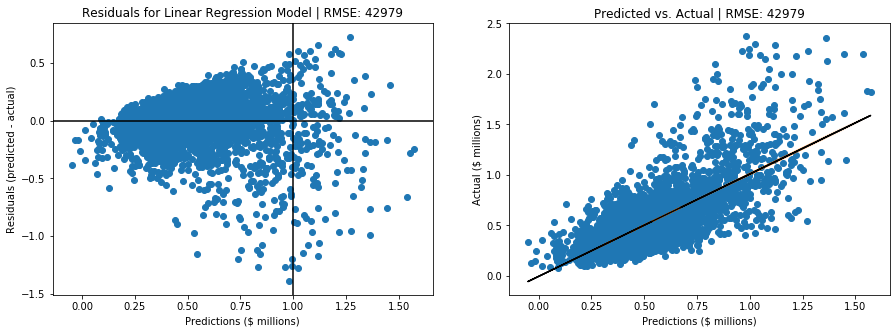

In [6]:
def scatter(model, x_test=x_test, y_test=y_test): 
    '''This function will create a scatter plot for the residuals of the model'''
    predictions = model.predict(x_test)
    residuals = predictions - y_test.values.squeeze() 
    
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    
    #residual plot
    ax[0].scatter(predictions, residuals)
    ax[0].axhline(y = 0, xmin = predictions.min(), xmax = predictions.max(), color = 'black')
    ax[0].axvline(x = 1,ymin = residuals.min(), ymax = 1, color = 'black')
    ax[0].set_xlabel('Predictions ($ millions)'); ax[0].set_ylabel('Residuals (predicted - actual)'); 
    loss = mean_squared_error(y_test, predictions)*1000000
    ax[0].set_title(f'Residuals for Linear Regression Model | RMSE: {int(round(loss, 0))}')
    
    #predictions vs actual 
    a,b = np.polyfit(predictions, y_test, deg = 1)
    y_est = a * predictions + b
    y_err = predictions.std() * np.sqrt(1/len(predictions)
                                        +(predictions - predictions.mean())**2 / 
                                        np.sum((predictions - predictions.mean())**2))
    ax[1].scatter(predictions, y_test)
    ax[1].set_xlabel('Predictions ($ millions)'); ax[1].set_ylabel('Actual ($ millions)')
    ax[1].set_title(f'Predicted vs. Actual | RMSE: {int(round(loss, 0))}')
    ax[1].plot(predictions, y_est, '-', color = 'black')
    ax[1].fill_between(predictions, y_est-y_err, y_est + y_err)
    
scatter(model = model)